In [1]:
import sys

sys.path.append("../tools")
sys.path.append("../tpot/")
import numpy as np
import pandas
import importlib
import json
import ot
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import glob
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

import random
import tqdm
from tqdm import tqdm
import seaborn as sb
import scipy as sp
import topo_util
from topo_util import noisy_circle, noisy_ellipses
import sklearn as sk
import sklearn.decomposition
import math
import pd
import hypernetx as hnx
import tpot
sys.path.append("../tools/topf/src/topf")
import topfmain

/opt/anaconda3/envs/tpot/lib/python3.9/site-packages/kaleido/_sync_server.py:11: UserWarning:




This means that static image generation (e.g. `fig.write_image()`) will not work.

Please upgrade Plotly to version 6.1.1 or greater, or downgrade Kaleido to version 0.2.1.




/opt/anaconda3/envs/tpot/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [2]:
def gen_pts(n_pts = 50, noise_level = 0, seed = 42):
    # Source point cloud
    np.random.seed(seed)
    data1 = noisy_circle(n_pts, 0.1*noise_level, 0, 0, 3 )
    data2 = noisy_circle(n_pts, 0.1*noise_level, 10, 0, 3 )
    A = np.concatenate([data1, data2])
    # Target point cloud
    np.random.seed(seed)
    data1 = noisy_circle(n_pts, 0.1*noise_level, 5, 0, 3 )
    data2 = noisy_circle(n_pts, 0.1*noise_level, 5, 3.48, 3 )
    B = np.concatenate([data1, data2])
    return A, B

n_pts = 50
A, B = gen_pts(n_pts = n_pts, noise_level = 1.0)

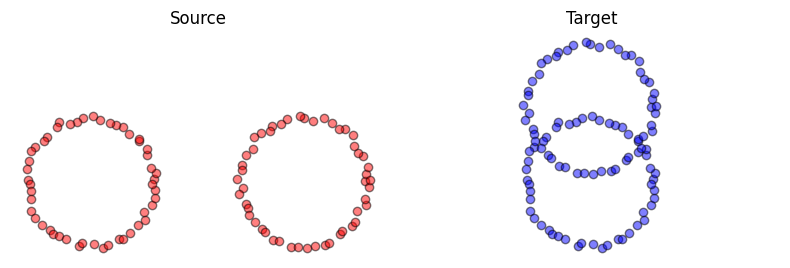

In [4]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(8,3), sharex=True, sharey=True)

# 源图
axes[0].scatter(A[:,0], A[:,1], color='red', edgecolors='k', alpha=0.5)
axes[0].set_aspect('equal', adjustable='box')
axes[0].axis("off")
axes[0].set_title("Source")

# 目标图
axes[1].scatter(B[:,0], B[:,1], color='blue', edgecolors='k', alpha=0.5)
axes[1].set_aspect('equal', adjustable='box')
axes[1].axis("off")
axes[1].set_title("Target")

plt.tight_layout()
plt.show()

In [5]:
# Compute pairwise distance matrices for source A and target B
def get_affinities(X, gaussian = True):
    C = sp.spatial.distance.cdist(X, X, metric = "sqeuclidean")
    C /= np.mean(C)
    if gaussian:
        C = np.exp(-C)
    return C
C_v0, C_v1 = get_affinities(A), get_affinities(B)
p, q = ot.unif(len(A)), ot.unif(len(B))

topf_all = [topfmain.topf(x, return_dict = True, complex_type = 'rips', fixed_num_features = [0, 5]) for x in tqdm([A, B])]
y0 = topf_all[0][0]
y1 = topf_all[1][0]
df1, df2 = [pandas.DataFrame({"b" : x[1]['birth_times'], "d" : x[1]['death_times'], "pers" : np.array(x[1]['death_times']) - np.array(x[1]['birth_times'])}) for x in topf_all]
p_spt, q_spt = df1.iloc[:, :2].values, df2.iloc[:, :2].values

# Get weights and cost on the PD space 
p, q = pd.augmented_weights(p_spt, q_spt)
C = pd.augmented_cost(p_spt, q_spt)
C_pd = pd.augmented_cost(p_spt, q_spt); C_pd /= C_pd.mean()

C_v0, C_v1 = get_affinities(A), get_affinities(B)

alpha = 0.5
beta = 2.5
#alpha = 1
#beta = 0

w0 = ot.unif(y0.shape[0])
w1 = ot.unif(y1.shape[0])
v0 = p
v1 = q
pi_s, pi_f, _, = tpot.TPOT(y0, y1, w0, w1, v0, v1, 
                           C_v0, C_v1, C_pd, 
                           beta = beta, alpha = alpha, print_iter = 10, iter = 100,
                           solver = "sinkhorn", 
                           eps_s = 0.003, eps_f = 0.01, numItermax = 2500)

P = (pi_s / pi_s.sum(axis=-1)[:, np.newaxis])
Q = (pi_f[:-1, :-1] / pi_f[:-1, :-1].sum(axis=-1)[:, np.newaxis])
Q[np.isnan(Q)] = 0



100%|██████████| 2/2 [00:16<00:00,  8.17s/it]


Iteration 0,	 obj = 0.36813935621943616,	 obj_terms = {'coot': 0.22026111456647704, 'ot': 0.10726790404932564, 'gw': 0.0406103376036335}
Iteration 10,	 obj = 0.22370924497687833,	 obj_terms = {'coot': 0.10127790214282444, 'ot': 0.10727720181101397, 'gw': 0.015154141023039934}
Iteration 20,	 obj = 0.2231919494289406,	 obj_terms = {'coot': 0.10128824019900476, 'ot': 0.10727821960709413, 'gw': 0.014625489622841732}
Iteration 30,	 obj = 0.22319223106492975,	 obj_terms = {'coot': 0.10128825515100906, 'ot': 0.10727852551562744, 'gw': 0.014625450398293261}
Iteration 40,	 obj = 0.22319242517544463,	 obj_terms = {'coot': 0.10128829711662844, 'ot': 0.10727868115386051, 'gw': 0.014625446904955694}
Iteration 50,	 obj = 0.2231925450139554,	 obj_terms = {'coot': 0.10128832441849489, 'ot': 0.10727877526589276, 'gw': 0.014625445329567756}
Iteration 60,	 obj = 0.22319262662713218,	 obj_terms = {'coot': 0.10128834401309889, 'ot': 0.10727883831107082, 'gw': 0.01462544430296248}
Iteration 70,	 obj = 0.223

In [ ]:
sys.path.append("../src/")
from entropy import persist_entropy, hyper_graph_entropy, hyper_edge_entropy, hypergraph_shannon_entropy
from geodesic import geodesic_distances, convex_point, geodesic_distances_gw, geodesic_distances_coot, geodesic_distances_iota
# Find geodesic
matching = np.array(np.where(ot.emd(w0, w1, pi_s.max()-pi_s) > 0)).T # round coupling


point_matching = []
pi_s_T = pi_s.T
for i in range(len(pi_s_T[:][-1])):
    sorted_indices = np.argsort(pi_s_T[i])
    point_matching.append([i, sorted_indices[-1]])



cycle_matching = []
pi_f_T = pi_f.T
for i in range(len(pi_f_T[:][-1])):
    sorted_indices = np.argsort(pi_f_T[i])
    cycle_matching.append([i, sorted_indices[-1]])
def geodesic_distances_iota(a,b,t,indices):
    #Compute pairwise distance between points in geodesic
    N = len(indices)-1
    M = np.zeros((N, 2))
    for ii in range(N):
        if indices[ii][1] == N:
            Pi = a[indices[ii][0]]
            Qi = [(Pi[0]+Pi[1])/2, (Pi[0]+Pi[1])/2]
        else:
            Pi = a[indices[ii][0]]
            Qi = b[indices[ii][1]]
        #Pi = np.array(Pi)
        #Qi = np.array(Qi)
        M[ii][0] = t*Pi[0] + (1-t)*Qi[0]
        M[ii][1] = t*Pi[1] + (1-t)*Qi[1]
    return M


import numpy as np
from coot import dot, eta

def compute_coot_ot_gw_distances(X1, X2, C1, C2, C_pd, pi_s, pi_f, alpha, beta):
    # 添加零列处理扩展矩阵
    _X1 = np.hstack([X1, np.zeros((X1.shape[0], 1))])
    _X2 = np.hstack([X2, np.zeros((X2.shape[0], 1))])
    
    # 计算COOT项
    coot_term = dot(
        eta(_X1, _X2, pi_f.sum(-1), pi_f.sum(0)) - _X1 @ pi_f @ _X2.T,
        pi_s
    )
    
    # 计算OT项
    ot_term = dot(C_pd, pi_f)
    
    # 计算GW项
    gw_term = dot(
        eta(C1, C2, pi_s.sum(-1), pi_s.sum(0)) - C1 @ pi_s @ C2.T,
        pi_s
    )
    
    # 应用权重参数
    coot_dist = beta * coot_term
    ot_dist = (1 - alpha) * ot_term
    gw_dist = alpha * gw_term
    
    return coot_dist, ot_dist, gw_dist


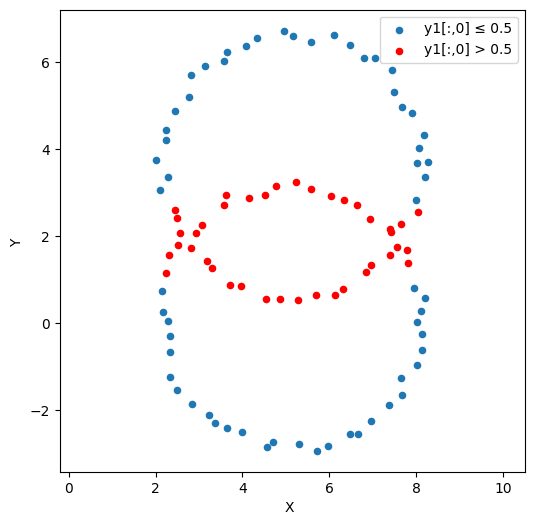

In [ ]:
mask = y1[:, 2] > 0.5  


plt.figure(figsize=(6, 6))
plt.scatter(B[~mask, 0], B[~mask, 1], s=20, label='y1[:,0] ≤ 0.5')
plt.scatter(B[mask, 0],  B[mask, 1],  s=20, label='y1[:,0] > 0.5', c='red')
plt.legend()
plt.xlabel('X ')
plt.ylabel('Y ')
plt.axis('equal')  
plt.show()

In [ ]:
num_frames = 100
x1 = np.linspace(0, 1, num_frames, endpoint=True)
matrices = [geodesic_distances(A,B,t, matching) for t in x1]
convex_points = np.array([convex_point(A,B,t, matching) for t in x1])

from sklearn.metrics import pairwise_distances
from sklearn.manifold import MDS
from matplotlib.collections import LineCollection
from sklearn import manifold
from sklearn.metrics import euclidean_distances

model = MDS(n_components=2, dissimilarity='precomputed', random_state=2002)

from scipy.spatial.transform import Rotation as R
def align(AA,BB):
    AA = [[aa[0], aa[1], 0] for aa in AA]
    BB = [[aa[0], aa[1], 0] for aa in BB]
    rot, rssd, sens = R.align_vectors(BB, AA, return_sensitivity=True)
    return rot.apply(AA)[:,:2]
def reflect(a):
    return np.array([ [aa[0], -aa[1]] for aa in a ])

import warnings
warnings.filterwarnings("ignore")
models = []
out = model.fit(matrices[0]).embedding_
pos = align(out, convex_points[0])
models_alligned = [pos]
for ii in range(1, num_frames):
    true = convex_points[ii]
    out = model.fit(matrices[ii]).embedding_
    pos = align(out, true)
    rpos = reflect(pos)
    #if np.linalg.norm(models_alligned[-1] - pos) >  np.linalg.norm(models_alligned[-1] - rpos):
    #    pos = rpos
    models.append(out)
    models_alligned.append(pos)

frames = []
for i in range(0, num_frames):
    df = pandas.DataFrame()
    df['x'] = list(np.array(models_alligned[i]).T[0])
    df['y'] = list(np.array(models_alligned[i]).T[1])
    df['frame'] = i
    df['color'] = np.concatenate([[0 for jj in range(50)],[0.33 for jj in range(50)]])#,[0.66 for jj in range(50)],[1 for jj in range(50)]])
    frames.append(df)

DF = pandas.concat(frames)
DF['size'] = 3

new_scale=[
                [0.0,'orange'],
                [0.33, 'red'],
                [0.66, 'purple'],
                [1.0, 'blue']]
df = px.data.gapminder()
fig = px.scatter(DF, x="x", y="y", animation_frame="frame",size='size', size_max=10, color= 'color',
                 color_continuous_scale= new_scale,
            )
fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 30
fig.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 5
fig.update_yaxes(
    scaleanchor = "x",
    scaleratio = 1,
  )
    #plt.savefig('outputs/loops_geo_{}.png'.format(j))
    #plt.savefig('outputs/loops_geo_{}.pdf'.format(j))
fig.update_layout(
    width = 600,
    height = 500,
)
fig.show()


In [ ]:
import numpy as np
import pandas
import plotly.express as px
from plotly.subplots import make_subplots

num_frames = len(models_alligned)

# Build DataFrame for all frames
frames = []
for i, cloud in enumerate(models_alligned):
    df = pandas.DataFrame({
        'x': cloud[:, 0],
        'y': cloud[:, 1],
        'frame': i,
        'size': 2,                            # smaller marker size
        'color': [0]*50 + [0.33]*50           # adjust as needed
    })
    frames.append(df)
DF = pandas.concat(frames, ignore_index=True)

# Pick 5 evenly spaced frame indices
indices = np.linspace(0, num_frames-1, 5, dtype=int)

# Compute global axis limits
xmin, xmax = DF['x'].min(), DF['x'].max()
ymin, ymax = DF['y'].min(), DF['y'].max()

# Create 1×5 subplot grid
fig = make_subplots(
    rows=1, cols=5,
    subplot_titles=[f"t={i/num_frames}" for i in indices],
    shared_xaxes=True, shared_yaxes=True
)

# Color scale
scale = [[0.0,'orange'], [0.33,'red'], [0.66,'purple'], [1.0,'blue']]

# Add each selected frame as a scatter trace
for col, idx in enumerate(indices, start=1):
    df_i = DF[DF['frame'] == idx]
    trace = px.scatter(
        df_i, x='x', y='y',
        size='size', size_max=4,             # limit max marker size
        color='color',
        color_continuous_scale=scale
    ).data[0]
    fig.add_trace(trace, row=1, col=col)
    # Fix axes and enforce equal aspect
    fig.update_xaxes(range=[xmin, xmax], row=1, col=col)
    fig.update_yaxes(range=[ymin, ymax], scaleanchor='x', scaleratio=1, row=1, col=col)

# Layout adjustments
fig.update_layout(
    width=1200, height=300,
    showlegend=False,
    margin=dict(l=20, r=20, t=30, b=20)
)

# Save to file (requires install of kaleido: pip install -U kaleido)
#fig.write_image("aligned_interpolation_snapshots.png", scale=2)

# Optionally also display
fig.show()

In [ ]:

num_frames = 100
coot_values = []
ot_values = []
gw_values = []
total_values = []
pe_values = []#persistent entropy
hge_values = []#hyper graph entropy(new defined)
hse_values = []#hypergraph shannon entropy
hee_values = []#hyperedge entropy
geodesic_pd = []#PD on the geodesic
sym_values = []#symmetric hypergraph entropy
geodesic_pd.append(p_spt)

para_alpha = 0.5
for i in range(1,num_frames):
    t = i/num_frames
    y1_t = geodesic_distances_coot(y1,y0,t,point_matching,cycle_matching)
    C2_t = geodesic_distances_gw(B,A,t, point_matching)
    geodesic_pd_point = geodesic_distances_iota(q_spt, p_spt, t, cycle_matching)

    if i%20 == 0:
        geodesic_pd.append(geodesic_pd_point)

    pe_value = persist_entropy(geodesic_pd_point)
    hge_value = hyper_graph_entropy(y1_t)
    hee_value = hyper_edge_entropy(y1_t)
    hse_value = hypergraph_shannon_entropy(y1_t)
    #new_hge_value = new_hyper_graph_entropy(y1_t)

    p, q = pd.augmented_weights(p_spt, geodesic_pd_point)
    C = pd.augmented_cost(p_spt, geodesic_pd_point)
    C_pd_t = pd.augmented_cost(p_spt, geodesic_pd_point); C_pd_t /= C_pd_t.mean()
    C_v1_t = C2_t
    C_v1_t /= np.mean(C2_t)
    C_v1_t = np.exp(-C_v1_t)
    value = compute_coot_ot_gw_distances(y0, y1_t,
                           C_v0, C_v1_t, C_pd_t, 
                           pi_s, pi_f,
                           alpha = alpha, beta=beta)
    coot_values.append(value[0])
    ot_values.append(value[1])
    gw_values.append(value[2])
    total_values.append(value[0]+value[1]+value[2])

    pe_values.append(pe_value)
    hge_values.append(hge_value)
    hee_values.append(hee_value)
    hse_values.append(hse_value)
    sym_values.append(para_alpha * hge_value + (1-para_alpha) * hee_value)
    print(f'Time Stamp:{i}')

hse_rate = [hse_values[i] - hse_values[i-1] for i in range(1,len(hse_values))]
hge_rate = [hge_values[i] - hge_values[i-1] for i in range(1,len(hge_values))]


Time Stamp:1
Time Stamp:2
Time Stamp:3
Time Stamp:4
Time Stamp:5
Time Stamp:6
Time Stamp:7
Time Stamp:8
Time Stamp:9
Time Stamp:10
Time Stamp:11
Time Stamp:12
Time Stamp:13
Time Stamp:14
Time Stamp:15
Time Stamp:16
Time Stamp:17
Time Stamp:18
Time Stamp:19
Time Stamp:20
Time Stamp:21
Time Stamp:22
Time Stamp:23
Time Stamp:24
Time Stamp:25
Time Stamp:26
Time Stamp:27
Time Stamp:28
Time Stamp:29
Time Stamp:30
Time Stamp:31
Time Stamp:32
Time Stamp:33
Time Stamp:34
Time Stamp:35
Time Stamp:36
Time Stamp:37
Time Stamp:38
Time Stamp:39
Time Stamp:40
Time Stamp:41
Time Stamp:42
Time Stamp:43
Time Stamp:44
Time Stamp:45
Time Stamp:46
Time Stamp:47
Time Stamp:48
Time Stamp:49
Time Stamp:50
Time Stamp:51
Time Stamp:52
Time Stamp:53
Time Stamp:54
Time Stamp:55
Time Stamp:56
Time Stamp:57
Time Stamp:58
Time Stamp:59
Time Stamp:60
Time Stamp:61
Time Stamp:62
Time Stamp:63
Time Stamp:64
Time Stamp:65
Time Stamp:66
Time Stamp:67
Time Stamp:68
Time Stamp:69
Time Stamp:70
Time Stamp:71
Time Stamp:72
T

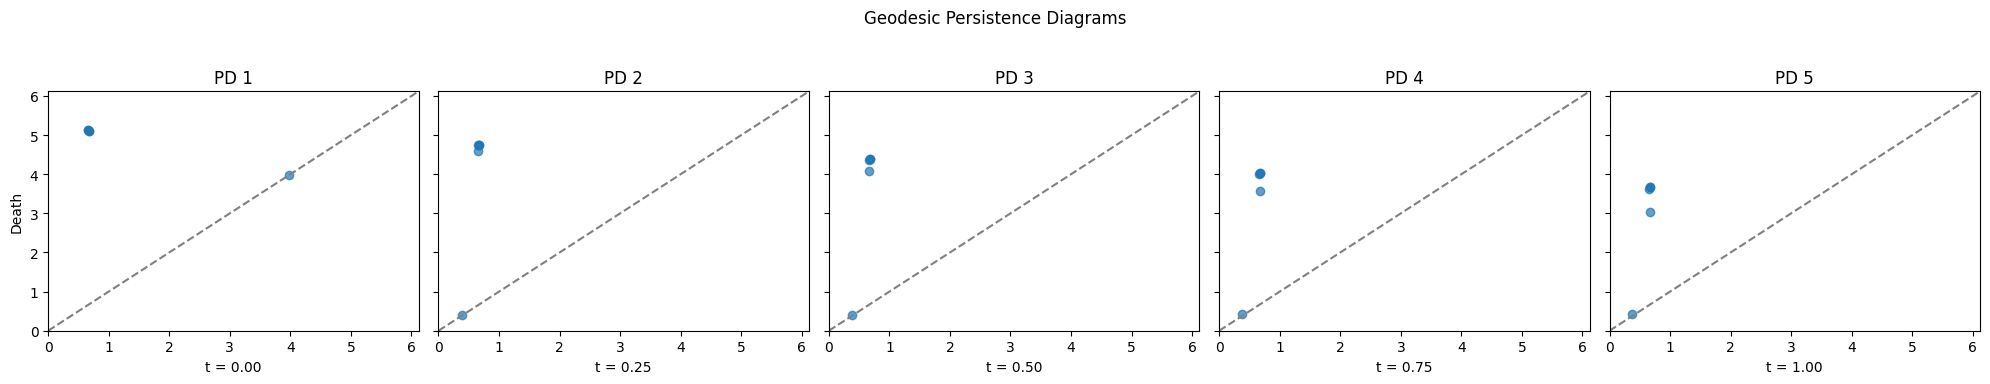

In [13]:
import matplotlib.pyplot as plt

def plot_geodesic_pds(geodesic_pd):
    """
    在一行里并排绘制所有 geodesic_pd 中的持久性图（[birth, death] 对）
    x 轴用 t 从 0 到 1 均匀分布标注
    """
    n = len(geodesic_pd)
    fig, axes = plt.subplots(1, n, figsize=(4 * n, 4), sharey=True)
    max_value = np.max(geodesic_pd)
    for i, pd in enumerate(geodesic_pd):
        ax = axes[i]
        births = pd[:, 0]
        deaths = pd[:, 1]
        ax.scatter(births, deaths, alpha=0.7)
        ax.plot([0, max_value+1], [0, max_value+1], linestyle='--', color='gray')
        ax.set_xlim(0, max_value+1)
        ax.set_ylim(0, max_value+1)
        t_val = i / (n - 1) if n > 1 else 0
        ax.set_xlabel(f"t = {t_val:.2f}")
        if i == 0:
            ax.set_ylabel("Death")
        ax.set_title(f"PD {i+1}")

    fig.suptitle("Geodesic Persistence Diagrams")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()



plot_geodesic_pds(geodesic_pd)

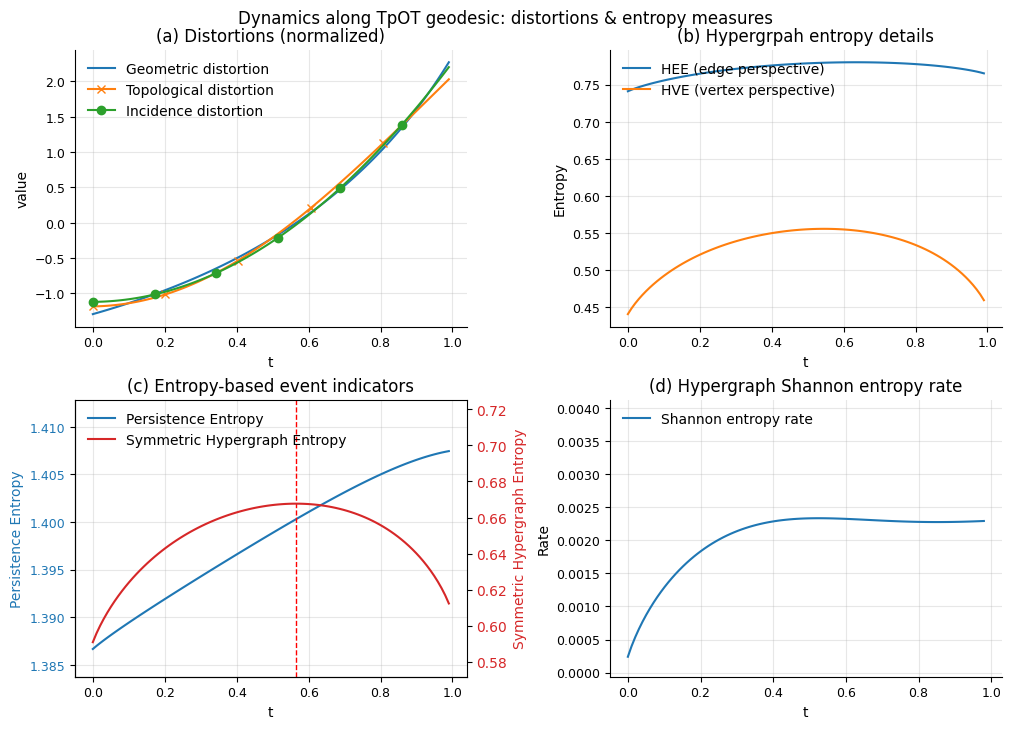

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# x 
x = np.arange(len(ot_values))

# distortions
geom = np.asarray(gw_values)      
topo = np.asarray(ot_values)       
hyper = np.asarray(coot_values)      

# entropied
PE = np.asarray(pe_values)           # Persistence entropy
HE = np.asarray(hge_values)          # Hypergraph entropy
HEE = np.asarray(hee_values)         # Hyperedge-perspective entropy
SHE = np.asarray(sym_values)         # Symmetric hypergraph entropy
HSE = np.asarray(hse_values)


HSE_rate = np.asarray(hse_rate)

#z-score
def zscore(y):
    y = np.asarray(y, dtype=float)
    m, s = np.nanmean(y), np.nanstd(y)
    return (y - m) / s if s > 0 else y * 0.0

geom_z, topo_z, hyper_z = map(zscore, [geom, topo, hyper])
PE_z, HE_z, HEE_z, SHE_z = map(zscore, [PE, HE, HEE, SHE])


event_idx = int(np.nanargmax(SHE))


# ==== 画图 ====
fig = plt.figure(figsize=(10, 7), constrained_layout=True)
gs = fig.add_gridspec(2, 2)

axA = fig.add_subplot(gs[0, 0])  # (a)
axB = fig.add_subplot(gs[1, 0])  # (c)
axC = fig.add_subplot(gs[0, 1])  # (b)
axD = fig.add_subplot(gs[1, 1])  # (d)

# (a) Distortions (z-score)
axA.plot(x/(num_frames-1), geom_z, label='Geometric distortion')
axA.plot(x/(num_frames-1), topo_z, label='Topological distortion', marker='x', markevery=20)
axA.plot(x/(num_frames-1), hyper_z, label='Incidence distortion', marker ='o', markevery=17)
#axA.axvline(event_idx/(num_frames-1), linestyle='--')
axA.set_title('(a) Distortions (normalized)')
axA.set_xlabel('t')
axA.set_ylabel('value')
axA.grid(True, alpha=0.3)
axA.legend(loc='upper left', ncol=1, frameon=False)

# (b) Entropy-based event indicators (dual-axis)
color_left = 'tab:blue'
color_right = 'tab:red'

# 左轴：Persistence Entropy
axB.plot(x / (num_frames - 1), PE, color=color_left, label='Persistence Entropy')
axB.set_xlabel('t')
axB.set_ylabel('Persistence Entropy', color=color_left)
axB.tick_params(axis='y', labelcolor=color_left)
axB.grid(True, alpha=0.3)

# 右轴：Symmetric Hypergraph Entropy
axB_r = axB.twinx()
axB_r.plot(x / (num_frames - 1), SHE, color=color_right, label='Symmetric Hypergraph Entropy')
axB_r.set_ylabel('Symmetric Hypergraph Entropy', color=color_right)
axB_r.tick_params(axis='y', labelcolor=color_right)

# ---- 缩小纵轴尺度：围绕平均值 ± 一点点 ----
she_mean = np.nanmean(SHE)
she_range = np.nanmax(SHE) - np.nanmin(SHE)
pe_mean = np.nanmean(PE)
pe_range = np.nanmax(PE) - np.nanmin(PE)
axB.set_ylim(pe_mean - 0.7 * pe_range, pe_mean + 0.7 * pe_range)
axB_r.set_ylim(she_mean - 1 * she_range, she_mean + 1 * she_range)

# 若需要事件线
axB.axvline(event_idx / (num_frames - 1), linestyle='--', color='red', linewidth=1)

# 标题与图例
axB.set_title('(c) Entropy-based event indicators')
lines, labels = axB.get_legend_handles_labels()
lines2, labels2 = axB_r.get_legend_handles_labels()
axB.legend(lines + lines2, labels + labels2, loc='upper left', frameon=False)

# 合并左右两轴的图例
lines, labels = axB.get_legend_handles_labels()
lines2, labels2 = axB_r.get_legend_handles_labels()
axB.legend(lines + lines2, labels + labels2, loc='upper left', frameon=False)

# (c) Vertex vs Edge incidence entropy
axC.plot(x/(num_frames-1), HEE, label='HEE (edge perspective)')
axC.plot(x/(num_frames-1), HE, label='HVE (vertex perspective)')
# axC.plot(x, HEV, label='HEV (vertex perspective)')
#axC.axvline(event_idx/(num_frames-1), linestyle='--')
axC.set_title('(b) Hypergrpah entropy details')
axC.set_xlabel('t')
axC.set_ylabel('Entropy')
axC.grid(True, alpha=0.3)
axC.legend(loc='upper left', ncol=1, frameon=False)

# (d) Shannon hypergraph entropy rate
axD.plot(x[:-1]/(num_frames-1), HSE_rate, label='Shannon entropy rate')
HSE_rate_mean = np.nanmean(HSE_rate)
HSE_rate_range = np.nanmax(HSE_rate) - np.nanmin(HSE_rate)
axD.set_ylim(HSE_rate_mean - 1 * HSE_rate_range, HSE_rate_mean + 1* HSE_rate_range)
#axD.axvline(event_idx/(num_frames-1), linestyle='--')
axD.set_title('(d) Hypergraph Shannon entropy rate')
axD.set_xlabel('t')
axD.set_ylabel('Rate')
axD.grid(True, alpha=0.3)
axD.legend(loc='upper left', ncol=1, frameon=False)

# 面板整体优化
for ax in [axA, axB, axC, axD]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=9)

fig.suptitle('Dynamics along TpOT geodesic: distortions & entropy measures', y=1.02)
plt.show()

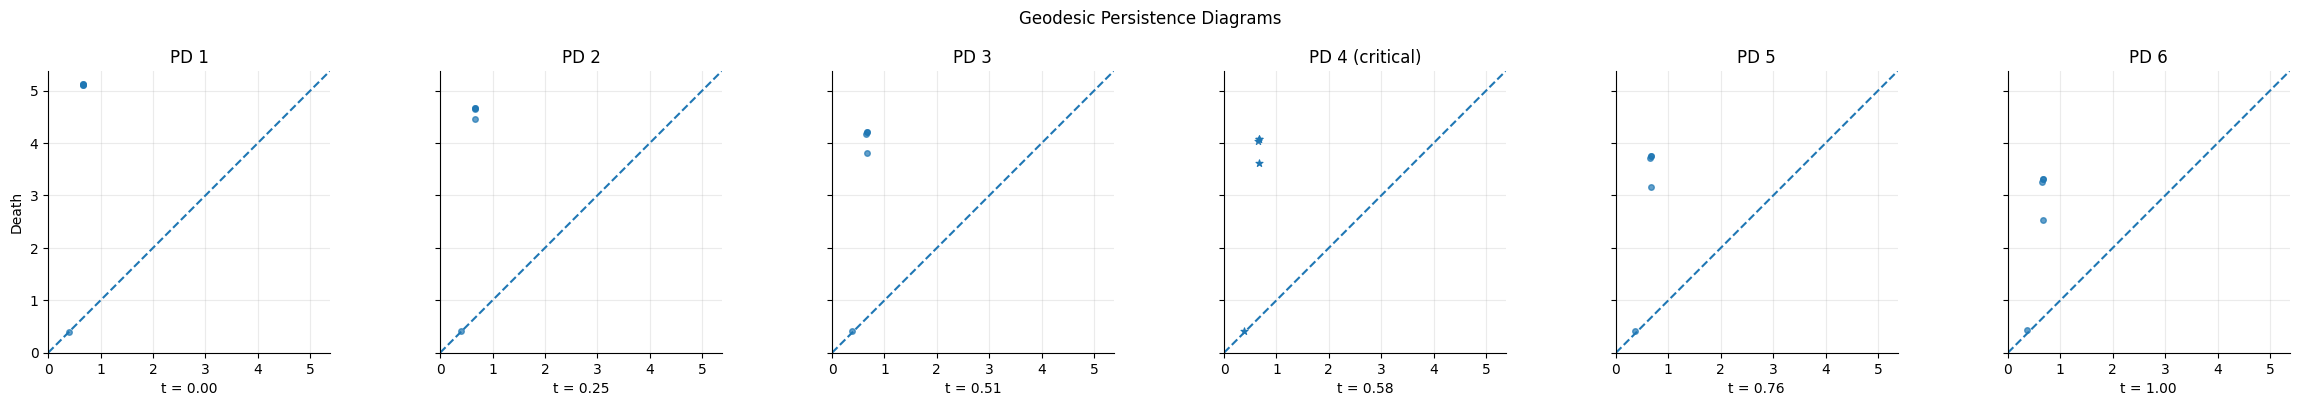

In [ ]:
#包含event_id的绘图
geodesic_pd = []  # 每项：{'pd': ndarray(k,2), 't': float, 'is_event': bool}

for i in range(num_frames):
    t = i / (num_frames - 1)  # [0,1]
    pd_i = geodesic_distances_iota(q_spt, p_spt, t, cycle_matching)
    is_event = i == event_idx + 1

    # 头尾 + 每 25 帧 + 关键帧
    if i == 0 or i == num_frames-1 or (i % 25 == 0) or is_event:
        geodesic_pd.append({'pd': pd_i, 't': (t), 'is_event': is_event})

import numpy as np
import matplotlib.pyplot as plt

def plot_geodesic_pds(geodesic_pd):
    n = len(geodesic_pd)
    fig, axes = plt.subplots(1, n, figsize=(4*n, 4), sharey=True)

    # 取所有 PD 的最大坐标用于统一坐标轴
    all_vals = np.concatenate([d['pd'].reshape(-1) for d in geodesic_pd])
    vmax = float(np.nanmax(all_vals))
    lim = vmax * 1.05 if vmax > 0 else 1.0

    # 允许 n==1 时 axes 不是数组
    if n == 1: axes = [axes]

    for i, d in enumerate(geodesic_pd):
        ax = axes[i]
        pd = d['pd']; t = d['t']; is_event = d['is_event']

        births = pd[:, 0]; deaths = pd[:, 1]
        # 普通帧：淡蓝圆点；关键帧：红色星标 + 较大 size
        if not is_event:
            ax.scatter(births, deaths, s=16, alpha=0.7)
        else:
            ax.scatter(births, deaths, s=28, marker='*', linewidths=0.8)

        # 对角线
        ax.plot([0, lim], [0, lim], linestyle='--')

        ax.set_xlim(0, lim); ax.set_ylim(0, lim)
        ax.set_aspect('equal', adjustable='box')
        ax.set_xlabel(f"t = {t:.2f}")
        if i == 0: ax.set_ylabel("Death")

        ttl = f"PD {i+1}" + (" (critical)" if is_event else "")
        ax.set_title(ttl)

        ax.grid(alpha=0.25)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    fig.suptitle("Geodesic Persistence Diagrams")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


plot_geodesic_pds(geodesic_pd)



In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots

num_frames = len(models_alligned)

# Build DataFrame for all frames
frames = []
for i, cloud in enumerate(models_alligned):
    cloud = np.asarray(cloud)
    assert cloud.ndim == 2 and cloud.shape[1] == 2, f"models_aligned[{i}] 必须是 (N,2)"
    N = cloud.shape[0]
    color_col = np.r_[np.zeros(N//2), np.full(N - N//2, 0.33)]
    size_col = np.full(N, 2.0)
    df = pd.DataFrame({
        'x': cloud[:, 0],
        'y': cloud[:, 1],
        'frame': i,
        'size': size_col,
        'color': color_col
    })
    frames.append(df)
DF = pd.concat(frames, ignore_index=True)

# ==== 选择 5 个帧，并强制包含关键帧 event_idx ====

# 基于等间隔取 5 帧
#indices = np.linspace(0, num_frames-1, 5, dtype=int).tolist()

indices = list(range(0, num_frames, 25))

# 确保最后一帧也在里面（如果不是25的倍数）
if (num_frames - 1) % 25 != 0:
    indices.append(num_frames - 1)

# 直接把关键帧加进去
indices.append(int(event_idx))

# 去重并排序
indices = sorted(set(indices))


# ==== 统一坐标范围 ====
xmin, xmax = DF['x'].min(), DF['x'].max()
ymin, ymax = DF['y'].min(), DF['y'].max()
dx, dy = xmax - xmin, ymax - ymin
pad_x = 0.03 * (dx if dx > 0 else 1.0)
pad_y = 0.03 * (dy if dy > 0 else 1.0)

# ==== 子图骨架 ====
fig = make_subplots(
    rows=1, cols=6,
    subplot_titles=[f"t={idx/num_frames} "if idx!=event_idx else f"t={(idx+1)/(num_frames)}" + (" (critical)" if idx==event_idx else "")
                    for idx in indices],
    shared_xaxes=True, shared_yaxes=True
)

# 连续色标
scale = [[0.0,'orange'], [0.33,'red'], [0.66,'purple'], [1.0,'blue']]

# ==== 逐列画图 ====
for col, idx in enumerate(indices, start=1):
    df_i = DF[DF['frame'] == idx]
    trace = px.scatter(
        df_i, x='x', y='y',
        size='size', size_max=4,
        color='color',
        color_continuous_scale=scale
    ).data[0]
    fig.add_trace(trace, row=1, col=col)

    fig.update_xaxes(range=[xmin - pad_x, xmax + pad_x], row=1, col=col)
    fig.update_yaxes(range=[ymin - pad_y, ymax + pad_y], scaleanchor='x', scaleratio=1, row=1, col=col)

# ==== 关键帧高亮（红框） ====
for col, idx in enumerate(indices, start=1):
    if idx != event_idx:
        continue
    ax_key = 'xaxis' + ('' if col == 1 else str(col))
    dom = fig.layout[ax_key].domain  # 该子图在纸面坐标的横向区间
    fig.add_shape(
        type="rect",
        xref="paper", yref="paper",
        x0=dom[0], x1=dom[1], y0=0.0, y1=1.0,
        line=dict(width=2, color='red'),
        fillcolor='rgba(255,0,0,0.12)',
        layer="below"
    )

fig.update_layout(
    width=1200, height=300,
    showlegend=False,
    margin=dict(l=20, r=20, t=40, b=20),
    title_text=" "
)

fig.show()


In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px


num_frames = len(models_alligned)


idx_to_show = num_frames - 1


cloud = np.asarray(models_alligned[idx_to_show])
assert cloud.ndim == 2 and cloud.shape[1] == 2, "该帧必须是 (N,2) 坐标"

N = cloud.shape[0]

labels = np.r_[np.zeros(N//2, dtype=int), np.ones(N - N//2, dtype=int)]
df = pd.DataFrame({"x": cloud[:, 0], "y": cloud[:, 1], "group": labels})

# ========= 坐标范围 =========
xmin, xmax = df["x"].min(), df["x"].max()
ymin, ymax = df["y"].min(), df["y"].max()
dx, dy = xmax - xmin, ymax - ymin
pad_x = 0.03 * (dx if dx > 0 else 1.0)
pad_y = 0.03 * (dy if dy > 0 else 1.0)

df["group"] = df["group"].astype(str)

# ========= 画图 =========
fig = px.scatter(
    df,
    x="x",
    y="y",
    color="group",
    color_discrete_sequence=["#2C95E1", "#A21212"],  # 两种颜色
    title=f"Gromov-Wasserstein based OT matching",
)

# 等比例轴 + 范围留白
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(range=[xmin - pad_x, xmax + pad_x])
fig.update_yaxes(range=[ymin - pad_y, ymax + pad_y])

fig.update_traces(marker=dict(size=4))
fig.update_coloraxes(showscale=False)
fig.update_layout(
    width=600,
    height=520,
    legend_title_text="Group",
    margin=dict(l=20, r=20, t=50, b=20),
)

fig.show()
